In [1]:
# =========================
# Imports & Config
# =========================
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GRU

DATASET_DIR = '/content/drive/MyDrive/Col/머신러닝 10주차/UCI HAR Dataset'

In [2]:
# =========================
# 1) Data Load Helpers
# =========================
def load_file(p):
    return pd.read_csv(p, header=None, sep=r"\s+", engine="python").values

def load_group(files, pref):
    return np.dstack([load_file(os.path.join(pref, f)) for f in files])

def load_dataset_group(g, root):
    pref = os.path.join(root, g, 'Inertial Signals')
    files = [f'total_acc_{a}_{g}.txt' for a in 'xyz'] + \
            [f'body_acc_{a}_{g}.txt' for a in 'xyz'] + \
            [f'body_gyro_{a}_{g}.txt' for a in 'xyz']
    X = load_group(files, pref)
    y = load_file(os.path.join(root, g, f'y_{g}.txt')).ravel().astype(int)
    return X, y

def load_dataset(root):
    trX, try_ = load_dataset_group('train', root)
    teX, tey  = load_dataset_group('test',  root)
    try_, tey = try_-1, tey-1
    return trX, try_, to_categorical(try_), teX, tey, to_categorical(tey)

In [3]:
# =========================
# 2) Load & Preprocess
# =========================
trainX, trainy, trainy_1h, testX, testy, testy_1h = load_dataset(DATASET_DIR)

# Standardize per channel
scaler = StandardScaler()
trainX = scaler.fit_transform(trainX.reshape(-1, trainX.shape[2])).reshape(trainX.shape).astype('float32')
testX  = scaler.transform(testX.reshape(-1,  testX.shape[2])).reshape(testX.shape).astype('float32')

# Train/Val split
X_train, X_val, y_train_1h, y_val_1h, y_train, y_val = train_test_split(
    trainX, trainy_1h, trainy, test_size=0.2, random_state=100, stratify=trainy
)

n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_1h.shape[1]

In [4]:
# =========================
# 3) Build Model (Simple GRU)
# =========================
inputs = Input(shape=(n_timesteps, n_features))
x = GRU(128, return_sequences=True)(inputs)
x = GRU(64)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(n_outputs, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128, 128)       │        53,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,718 (389.52 KB)

 Trainable params: 99,718 (389.52 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# =========================
# 4) Train
# =========================
history = model.fit(
    X_train, y_train_1h,
    epochs=10, batch_size=64,
    validation_data=(X_val, y_val_1h),
    verbose=1
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.5505 - loss: 1.2316 - val_accuracy: 0.8994 - val_loss: 0.3476
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8998 - loss: 0.2828 - val_accuracy: 0.9477 - val_loss: 0.1395
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9511 - loss: 0.1327 - val_accuracy: 0.9334 - val_loss: 0.1874
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9278 - loss: 0.1609 - val_accuracy: 0.9572 - val_loss: 0.1145
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9507 - loss: 0.1171 - val_accuracy: 0.9579 - val_loss: 0.1085
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9510 - loss: 0.1186 - val_accuracy: 0.9633 - val_loss: 0.1029
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9545 - loss: 0.1124 - val_accuracy: 0.9579 - val_loss: 0.1031
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9509 - loss: 0.1129 - val_accuracy: 0.9483 - v

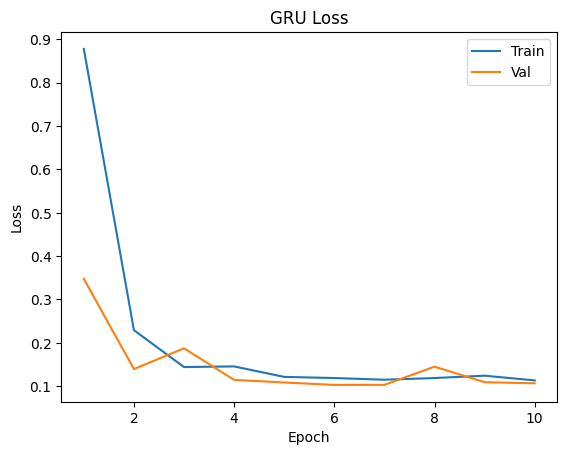

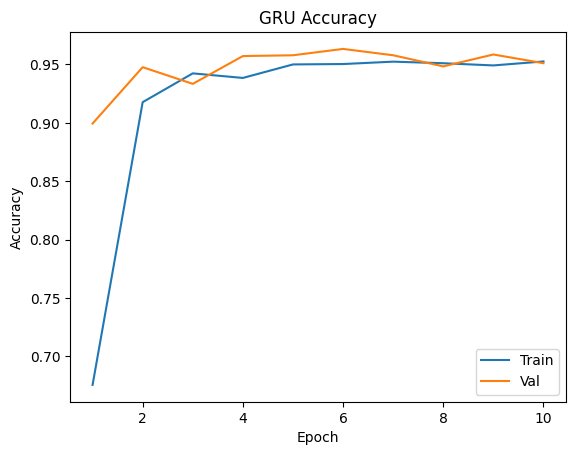

In [6]:
# =========================
# 5) Visualize Training
# =========================
ep = range(1, len(history.history['loss'])+1)
plt.figure(); plt.plot(ep, history.history['loss'], label='Train'); plt.plot(ep, history.history['val_loss'], label='Val');
plt.title('GRU Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()

plt.figure(); plt.plot(ep, history.history['accuracy'], label='Train'); plt.plot(ep, history.history['val_accuracy'], label='Val');
plt.title('GRU Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.show()

GRU Test Accuracy: 0.8941296233457754
              precision    recall  f1-score   support

           0     0.9591    0.9456    0.9523       496
           1     0.9095    0.8960    0.9027       471
           2     0.8681    0.9714    0.9169       420
           3     0.8341    0.7475    0.7884       491
           4     0.7997    0.8628    0.8300       532
           5     1.0000    0.9497    0.9742       537

    accuracy                         0.8941      2947
   macro avg     0.8951    0.8955    0.8941      2947
weighted avg     0.8960    0.8941    0.8939      2947



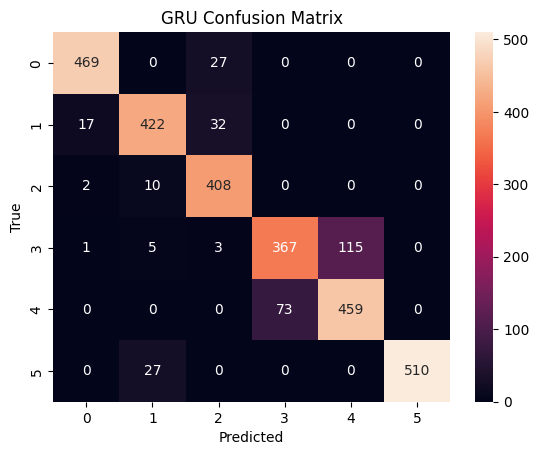

In [7]:
# =========================
# 6) Evaluate on Test
# =========================
probs = model.predict(testX, verbose=0)
pred = np.argmax(probs, axis=-1)
y_true = testy.ravel()

cm = confusion_matrix(y_true, pred)
print('GRU Test Accuracy:', accuracy_score(y_true, pred))
print(classification_report(y_true, pred, digits=4))

plt.figure(); sns.heatmap(cm, annot=True, fmt='d');
plt.title('GRU Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()